To do:

1.   Nomainīt komentārus un nosaukumus
2.   Iespēja eksportēt failu
3.   Iespēja apskatīt kategorizētus datus
4.   Analītiskie skati
5.   Iespēja apstrādāt vairākas bankas



1.   Pārbaudes funkcijās
2.   Atkārtoti izpildīt, ja neatrod
3.   Dot iespēju pārtraukt izdzēšanu
4.   Apskatīt datus no datubāzes



# Imports

In [ ]:
import gspread
import pprint
import pandas as pd
import io
import os
import datetime
import re
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import drive
from google.auth import default
from google.colab import auth
from google.colab import files

# Functions

## ADMIN

In [ ]:
def country_exists(worksheet, country):
        # Check if the country already exists in the specified worksheet
        country_list = worksheet.col_values(1)  # Assuming country names are in the first column (column A)
        return country in country_list

In [ ]:
def replace_data_with_admin():
    source_sheet_id = "1VdClU-WgifV2-rmrbyMmmAuVzYgoNQyMOP4zZdUhRMk"
    destination_sheet_id = "1M8Irao-sa7dC5e7_c0vQwcQ_ZEFHBZ2SMz5UBjZJrt4"

    # Open the source and destination sheets
    source_sheet = gc.open_by_key(source_sheet_id)
    destination_sheet = gc.open_by_key(destination_sheet_id)

    # Iterate through worksheets in the source sheet
    for source_worksheet in source_sheet.worksheets():
        try:
            # Get all values from the source worksheet
            data = source_worksheet.get_all_values()

            # Convert values to appropriate types
            converted_data = convert_values(data)

            # Find the corresponding worksheet in the destination sheet
            destination_worksheet = destination_sheet.worksheet(source_worksheet.title)

            # Clear existing data in the destination worksheet
            destination_worksheet.clear()

            # Update the values in the destination worksheet
            destination_worksheet.update(converted_data)

            print(f'Data replaced in {destination_worksheet.title}')
        except gspread.exceptions.WorksheetNotFound:
            print(f'Worksheet {source_worksheet.title} not found in {destination_sheet.title}')

In [ ]:
def add_new_keyword():
    # Authenticate with Google Colab and Google Sheets API

    sheet_id = "1VdClU-WgifV2-rmrbyMmmAuVzYgoNQyMOP4zZdUhRMk"
    worksheet_title = "keywords"

    criteria = str(input("Criteria: "))
    while True:
      try:
          priority = int(input("Priority: "))
          if 0 <= priority <= 100:
              break  # If the input is a valid integer within the range, exit the loop
          else:
              print("Priority must be between 0 and 100. Please try again.")
      except ValueError:
          print("Invalid input. Please enter a valid integer.")
    while True:
      try:
          category = int(input("Category: "))
          if 1 <= category <= 22:
              break  # If the input is a valid integer within the range, exit the loop
          else:
              print("Category must be between 1 and 22. Please try again.")
      except ValueError:
          print("Invalid input. Please enter a valid integer.")

    sheet_id = "1VdClU-WgifV2-rmrbyMmmAuVzYgoNQyMOP4zZdUhRMk"
    worksheet_title = "countries"
    worksheet = gc.open_by_key(sheet_id).worksheet(worksheet_title)

    while True:
        country = input("Country: ")

        # Check if the entered country exists in the sheet
        if country in worksheet.col_values(1):  # Assuming country names are in the first column (column A)
            break
        else:
            print(f"{country} does not exist in the 'countries' sheet. Please try again.")

    data = [criteria, category, priority, country]
    try:
        # Open the Google Sheet by its ID
        sheet = gc.open_by_key(sheet_id)

        # Get the specified worksheet or create a new one if it doesn't exist
        try:
            worksheet = sheet.worksheet(worksheet_title)
        except gspread.exceptions.WorksheetNotFound:
            print("Worksheet not found")

        # Append a new row with the provided data
        worksheet.append_row(data)

        print(f'Row added to {worksheet.title}')
    except gspread.exceptions.SpreadsheetNotFound:
        print(f'Spreadsheet with ID {sheet_id} not found or no permission')

In [ ]:
def add_new_country():
    # Authenticate with Google Colab and Google Sheets API

    sheet_id = "1VdClU-WgifV2-rmrbyMmmAuVzYgoNQyMOP4zZdUhRMk"
    worksheet_title = "countries"

    # Input validation for the country code
    while True:
        country = input("Country (2 symbols): ")
        if len(country) == 2:
            break
        else:
            print("Invalid input. Please enter a two-letter country code.")

    try:
        # Open the Google Sheet by its ID
        sheet = gc.open_by_key(sheet_id)

        # Get the specified worksheet or create a new one if it doesn't exist
        try:
            worksheet = sheet.worksheet(worksheet_title)
        except gspread.exceptions.WorksheetNotFound:
            print("Worksheet not found")

        # Check if the country already exists
        if country_exists(worksheet, country):
            print(f"{country} already exists in the sheet. Not adding a duplicate entry.")
        else:
            # Append a new row with the provided data
            worksheet.append_row([country])
            print(f'Row added to {worksheet.title}')
    except gspread.exceptions.SpreadsheetNotFound:
        print(f'Spreadsheet with ID {sheet_id} not found or no permission')

In [ ]:
def delete_keyword():
    sheet_id = "1VdClU-WgifV2-rmrbyMmmAuVzYgoNQyMOP4zZdUhRMk"
    worksheet_title = "keywords"
    column_name = "Keyword"
    value_to_delete = input(str("Keyword to delete: "))

    try:
        # Open the Google Sheet by its ID
        sheet = gc.open_by_key(sheet_id)

        # Get the specified worksheet
        try:
            worksheet = sheet.worksheet(worksheet_title)
        except gspread.exceptions.WorksheetNotFound:
            print(f'Worksheet {worksheet_title} not found in {sheet.title}')
            return

        # Get all values from the worksheet
        data = worksheet.get_all_values()

        # Find the index of the row containing the specified value in the specified column
        column_index = data[0].index(column_name)
        row_to_delete = next((index for index, row in enumerate(data) if row[column_index] == value_to_delete), None)

        if row_to_delete is not None:
            # Delete the row
            worksheet.delete_row(row_to_delete + 1)  # Adjust for 1-based indexing in Google Sheets
            print(f'Row containing {value_to_delete} deleted from {worksheet.title}')
        else:
            print(f'Row containing {value_to_delete} not found in {worksheet.title}')
    except gspread.exceptions.SpreadsheetNotFound:
        print(f'Spreadsheet with ID {sheet_id} not found')

In [ ]:
def delete_country():
    sheet_id = "1VdClU-WgifV2-rmrbyMmmAuVzYgoNQyMOP4zZdUhRMk"
    worksheet_title = "countries"
    column_name = "Country"
    while True:
        value_to_delete = input("Country (2 symbols): ")
        if len(value_to_delete) == 2:
            break
        else:
            print("Invalid input. Please enter a two-letter country code.")

    try:
        # Open the Google Sheet by its ID
        sheet = gc.open_by_key(sheet_id)

        # Get the specified worksheet
        try:
            worksheet = sheet.worksheet(worksheet_title)
        except gspread.exceptions.WorksheetNotFound:
            print(f'Worksheet {worksheet_title} not found in {sheet.title}')
            return

        # Get all values from the worksheet
        data = worksheet.get_all_values()

        # Find the index of the row containing the specified value in the specified column
        column_index = data[0].index(column_name)
        row_to_delete = next((index for index, row in enumerate(data) if row[column_index] == value_to_delete), None)

        if row_to_delete is not None:
            # Delete the row
            worksheet.delete_row(row_to_delete + 1)  # Adjust for 1-based indexing in Google Sheets
            print(f'Row containing {value_to_delete} deleted from {worksheet.title}')
        else:
            print(f'Row containing {value_to_delete} not found in {worksheet.title}')
    except gspread.exceptions.SpreadsheetNotFound:
        print(f'Spreadsheet with ID {sheet_id} not found')

In [ ]:
def edit_keyword():
    # Authenticate with Google Colab and Google Sheets API

    sheet_id = "1VdClU-WgifV2-rmrbyMmmAuVzYgoNQyMOP4zZdUhRMk"
    worksheet_title = "keywords"

    try:
        # Open the Google Sheet by its ID
        sheet = gc.open_by_key(sheet_id)

        # Get the specified worksheet or create a new one if it doesn't exist
        try:
            worksheet = sheet.worksheet(worksheet_title)
        except gspread.exceptions.WorksheetNotFound:
            print("Worksheet not found")

        # Get the value of the keyword to edit
        keyword_to_edit = str(input("Enter the value of the keyword to edit: "))

        # Search for the keyword in the first column
        try:
            cell_to_edit = worksheet.find(keyword_to_edit)
        except gspread.exceptions.CellNotFound:
            print(f"Keyword '{keyword_to_edit}' not found.")
            return

        # Get the new values for the keyword
        new_criteria = str(input("Criteria: "))
        while True:
          try:
              new_priority = int(input("Priority: "))
              if 0 <= new_priority <= 100:
                  break  # If the input is a valid integer within the range, exit the loop
              else:
                  print("Priority must be between 0 and 100. Please try again.")
          except ValueError:
              print("Invalid input. Please enter a valid integer.")
        while True:
          try:
              new_category = int(input("Category: "))
              if 1 <= new_category <= 22:
                  break  # If the input is a valid integer within the range, exit the loop
              else:
                  print("Category must be between 1 and 22. Please try again.")
          except ValueError:
              print("Invalid input. Please enter a valid integer.")

        while True:
            new_country = input("Country: ")

            # Check if the entered country exists in the sheet
            if new_country in worksheet.col_values(1):  # Assuming country names are in the first column (column A)
                break
            else:
                print(f"{new_country} does not exist in the 'countries' sheet. Please try again.")

        # Update the values in the worksheet
        worksheet.update_cell(cell_to_edit.row, cell_to_edit.col, new_criteria)
        worksheet.update_cell(cell_to_edit.row, cell_to_edit.col + 1, new_category)
        worksheet.update_cell(cell_to_edit.row, cell_to_edit.col + 2, new_priority)
        worksheet.update_cell(cell_to_edit.row, cell_to_edit.col + 3, new_country)

        print(f'Keyword edited in {worksheet.title}')
    except gspread.exceptions.SpreadsheetNotFound:
        print(f'Spreadsheet with ID {sheet_id} not found or no permission')

In [ ]:
def edit_country():
    # Authenticate with Google Colab and Google Sheets API

    sheet_id = "1VdClU-WgifV2-rmrbyMmmAuVzYgoNQyMOP4zZdUhRMk"
    worksheet_title = "countries"

    try:
        # Open the Google Sheet by its ID
        sheet = gc.open_by_key(sheet_id)

        # Get the specified worksheet or create a new one if it doesn't exist
        try:
            worksheet = sheet.worksheet(worksheet_title)
        except gspread.exceptions.WorksheetNotFound:
            print("Worksheet not found")

        # Display the existing countries for the user to choose which one to edit
        countries = worksheet.col_values(1)[1:]  # Exclude header
        print("Existing countries:")
        for i, country in enumerate(countries, start=1):
            print(f"{i}. {country}")

        # Get the user's choice for the country to edit
        choice = int(input("Enter the number of the country to edit: ")) - 1
        while choice not in range(len(countries)):
            choice = int(input("Invalid choice. Enter the number of the country to edit: ")) - 1

        # Get the new value for the country
        while True:
          new_country = input("Country (2 symbols): ")
          if len(new_country) == 2:
              break
          else:
              print("Invalid input. Please enter a two-letter country code.")

        # Update the value in the worksheet
        cell_to_edit = worksheet.find(countries[choice])
        worksheet.update_cell(cell_to_edit.row, cell_to_edit.col, new_country)

        print(f'Country edited in {worksheet.title}')
    except gspread.exceptions.SpreadsheetNotFound:
        print(f'Spreadsheet with ID {sheet_id} not found or no permission')

## CATEGORIZATION

In [ ]:
#function to transliterate non-latin letters to latin letters
def replace_letters(text, letter_map):
    letter_dict = dict(letter_map)
    pattern = re.compile('|'.join(map(re.escape, letter_dict.keys())))
    replaced_text = pattern.sub(lambda m: letter_dict[m.group()], text)
    return replaced_text

In [ ]:
#letter mapping
letter_map = [['ä', 'ae'], ['æ', 'ae'], ['ǽ', 'ae'], ['ö', 'oe'], ['œ', 'oe'],
           ['ü', 'ue'], ['Ä', 'Ae'],
           ['Ü', 'Ue'], ['Ö', 'Oe'], ['À', 'A'], ['Á', 'A'], ['Â', 'A'],
           ['Ã', 'A'], ['Å', 'A'],
           ['Ǻ', 'A'], ['Ā', 'A'], ['Å', 'A'], ['Ă', 'A'], ['Ą', 'A'],
           ['Ǎ', 'A'], ['Ä', 'Ae'],
           ['à', 'a'], ['á', 'a'], ['â', 'a'], ['ã', 'a'], ['å', 'a'],
           ['ǻ', 'a'], ['ā', 'a'],
           ['ă', 'a'], ['ą', 'a'], ['ǎ', 'a'], ['ª', 'a'], ['Ç', 'C'],
           ['Ć', 'C'], ['Ĉ', 'C'],
           ['Ċ', 'C'], ['Č', 'C'], ['ç', 'c'], ['ć', 'c'], ['ĉ', 'c'],
           ['ċ', 'c'], ['č', 'c'],
           ['Ð', 'D'], ['Ď', 'D'], ['Đ', 'D'], ['ð', 'd'], ['ď', 'd'],
           ['đ', 'd'], ['È', 'E'],
           ['É', 'E'], ['Ê', 'E'], ['Ë', 'E'], ['Ē', 'E'], ['Ĕ', 'E'],
           ['Ė', 'E'], ['Ę', 'E'],
           ['Ě', 'E'], ['Ë', 'E'], ['è', 'e'], ['é', 'e'], ['ê', 'e'],
           ['ë', 'e'], ['ē', 'e'],
           ['ĕ', 'e'], ['ė', 'e'], ['ę', 'e'], ['ě', 'e'], ['Ĝ', 'G'],
           ['Ğ', 'G'], ['Ġ', 'G'],
           ['Ģ', 'G'], ['Ґ', 'G'], ['ĝ', 'g'], ['ğ', 'g'], ['ġ', 'g'],
           ['ģ', 'g'], ['ґ', 'g'],
           ['Ĥ', 'H'], ['Ħ', 'H'], ['ĥ', 'h'], ['ħ', 'h'], ['І', 'I'],
           ['Ì', 'I'], ['Í', 'I'],
           ['Î', 'I'], ['Ї', 'Yi'], ['Ï', 'I'], ['Ĩ', 'I'], ['Ī', 'I'],
           ['Ĭ', 'I'], ['Ǐ', 'I'],
           ['Į', 'I'], ['İ', 'I'], ['і', 'i'], ['ì', 'i'], ['í', 'i'],
           ['î', 'i'], ['ï', 'i'],
           ['ї', 'yi'], ['ĩ', 'i'], ['ī', 'i'], ['ĭ', 'i'], ['ǐ', 'i'],
           ['į', 'i'], ['ı', 'i'],
           ['Ĵ', 'J'], ['ĵ', 'j'], ['Ķ', 'K'], ['ķ', 'k'], ['Ĺ', 'L'],
           ['Ļ', 'L'], ['Ľ', 'L'],
           ['Ŀ', 'L'], ['Ł', 'L'], ['ĺ', 'l'], ['ļ', 'l'], ['ľ', 'l'],
           ['ŀ', 'l'], ['ł', 'l'],
           ['Ñ', 'N'], ['Ń', 'N'], ['Ņ', 'N'], ['Ň', 'N'], ['ñ', 'n'],
           ['ń', 'n'], ['ņ', 'n'],
           ['ň', 'n'], ['ŉ', 'n'], ['Ò', 'O'], ['Ó', 'O'], ['Ô', 'O'],
           ['Õ', 'O'], ['Ō', 'O'],
           ['Ŏ', 'O'], ['Ǒ', 'O'], ['Ő', 'O'], ['Ơ', 'O'], ['Ø', 'O'],
           ['Ǿ', 'O'], ['Ö', 'Oe'],
           ['ò', 'o'], ['ó', 'o'], ['ô', 'o'], ['õ', 'o'], ['ō', 'o'],
           ['ŏ', 'o'], ['ǒ', 'o'],
           ['ő', 'o'], ['ơ', 'o'], ['ø', 'o'], ['ǿ', 'o'], ['º', 'o'],
           ['Ŕ', 'R'], ['Ŗ', 'R'],
           ['Ř', 'R'], ['ŕ', 'r'], ['ŗ', 'r'], ['ř', 'r'], ['Ś', 'S'],
           ['Ŝ', 'S'], ['Ş', 'S'],
           ['Ș', 'S'], ['Š', 'S'], ['ẞ', 'SS'], ['ś', 's'], ['ŝ', 's'],
           ['ş', 's'], ['ș', 's'],
           ['š', 's'], ['ſ', 's'], ['Ţ', 'T'], ['Ț', 'T'], ['Ť', 'T'],
           ['Ŧ', 'T'], ['ţ', 't'],
           ['ț', 't'], ['ť', 't'], ['ŧ', 't'], ['Ù', 'U'], ['Ú', 'U'],
           ['Û', 'U'], ['Ũ', 'U'],
           ['Ū', 'U'], ['Ŭ', 'U'], ['Ů', 'U'], ['Ű', 'U'], ['Ų', 'U'],
           ['Ư', 'U'], ['Ǔ', 'U'],
           ['Ǖ', 'U'], ['Ǘ', 'U'], ['Ǚ', 'U'], ['Ǜ', 'U'], ['Ü', 'Ue'],
           ['ù', 'u'], ['ú', 'u'],
           ['û', 'u'], ['ũ', 'u'], ['ū', 'u'], ['ŭ', 'u'], ['ů', 'u'],
           ['ű', 'u'], ['ų', 'u'],
           ['ư', 'u'], ['ǔ', 'u'], ['ǖ', 'u'], ['ǘ', 'u'], ['ǚ', 'u'],
           ['ǜ', 'u'], ['Ý', 'Y'],
           ['Ÿ', 'Y'], ['Ŷ', 'Y'], ['ý', 'y'], ['ÿ', 'y'], ['ŷ', 'y'],
           ['Ŵ', 'W'], ['ŵ', 'w'],
           ['Ź', 'Z'], ['Ż', 'Z'], ['Ž', 'Z'], ['ź', 'z'], ['ż', 'z'],
           ['ž', 'z'], ['Æ', 'AE'],
           ['Ǽ', 'AE'], ['ß', 'ss'], ['Ĳ', 'IJ'], ['ĳ', 'ij'], ['Œ', 'OE'],
           ['ƒ', 'f'], ['Þ', 'TH'],
           ['þ', 'th'], ['Є', 'Ye'], ['є', 'ye'], ['А', 'a'], ['Б', 'b'],
           ['В', 'v'], ['Г', 'g'],
           ['Д', 'd'], ['Е', 'e'], ['Ё', 'jo'], ['Ж', 'zh'], ['З', 'z'],
           ['И', 'i'], ['Й', 'j'],
           ['К', 'k'], ['Л', 'l'], ['М', 'm'], ['Н', 'n'], ['О', 'o'],
           ['П', 'p'], ['Р', 'r'],
           ['С', 's'], ['Т', 't'], ['У', 'u'], ['Ф', 'f'], ['Х', 'h'],
           ['Ц', 'c'], ['Ч', 'ch'],
           ['Ш', 'sh'], ['Щ', 'sch'], ['Ъ', ''], ['Ы', 'y'], ['Ь', ''],
           ['Э', 'e'], ['Ю', 'ju'],
           ['Я', 'ja'], ['а', 'a'], ['б', 'b'], ['в', 'v'], ['г', 'g'],
           ['д', 'd'], ['е', 'e'],
           ['ё', 'jo'], ['ж', 'zh'], ['з', 'z'], ['и', 'i'], ['й', 'j'],
           ['к', 'k'], ['л', 'l'],
           ['м', 'm'], ['н', 'n'], ['о', 'o'], ['п', 'p'], ['р', 'r'],
           ['с', 's'], ['т', 't'],
           ['у', 'u'], ['ф', 'f'], ['х', 'h'], ['ц', 'c'], ['ч', 'ch'],
           ['ш', 'sh'], ['щ', 'sch'],
           ['ъ', ''], ['ы', 'y'], ['ь', ''], ['э', 'e'], ['ю', 'ju'],
           ['я', 'ja'], ['№', 'No'],
           ['\xad', '-'], ['Α', 'A'], ['Β', 'B'], ['Γ', 'G'], ['Δ', 'D'],
           ['Ε', 'E'], ['Ζ', 'Z'],
           ['Η', 'H'], ['Θ', 'Th'], ['Ι', 'I'], ['Κ', 'K'], ['Μ', 'M'],
           ['Λ', 'L'], ['Ν', 'N'],
           ['Ο', 'O'], ['Ξ', 'X'], ['Π', 'P'], ['Ρ', 'P'], ['Σ', 'S'],
           ['Υ', 'Y'], ['Φ', 'F'],
           ['Τ', 'T'], ['Χ', 'x'], ['Ψ', 'Ps'], ['Ω', 'O'], ['α', 'a'],
           ['β', 'b'], ['γ', 'y'],
           ['δ', 'd'], ['ε', 'e'], ['ζ', 'z'], ['η', 'h'], ['θ', 'th'],
           ['ι', 'i'], ['κ', 'k'],
           ['λ', 'l'], ['μ', 'm'], ['ν', 'n'], ['ξ', 'x'], ['π', 'p'],
           ['ρ', 'p'], ['ς', 's'],
           ['σ', 's'], ['τ', 't'], ['υ', 'u'], ['φ', 'f'], ['χ', 'x'],
           ['ψ', 'ps'], ['ω', 'o'],
           ['έ', 'e'], ['ώ', 'o'], ['ά', 'a'], ['ί', 'i'], ['ή', 'e'],
           ['ό', 'o'], ['ύ', 'n'], ['ο', 'o'], ['ا', 'a'], ['أ', "a"],
           ['إ', "'i"], ['ب', 'b'], ["ت", "ta"], ['ث', 'tha'], ['ج', 'y'],
           ['ح', 'h'], ['خ', 'kha'], ['د', 'd'], ['ذ', 'th'], ['ر', 'r'],
           ['ز', 'z'], ['س', 's'], ['ش', 'sh'], ['ص', 'sa'], ['ض', 'da'],
           ['ط', 'ta'], ['ظ', 'th'], ['ع', 'a'], ['غ', 'gh'], ['ف', 'f'],
           ['ق', 'q'], ['ك', 'k'], ['ل', 'l'], ['م', 'm'], ['ن', 'n'],
           ['ه', 'h'], ['و', 'o'], ['ي', 'ee'], ['ة', 'ah'],
           ['ى', 'a'], ['ئ', "e'"], [' ', ' ']]

In [ ]:
def fetch_categories(cursor, typ):
    categories = []

    for i in range(100, 0, -1):
        cursor.execute("SELECT criteria, category_name, type FROM Keyword join Category on Keyword.category = Category.category_id WHERE priority = ? and type = ?", (i, typ))
        columns = [desc[0] for desc in cursor.description]
        adf = pd.DataFrame(cursor.fetchall(), columns=columns)

        this_cat = []
        for index, row in adf.iterrows():
            this_cat.append((adf.at[index, 'criteria'], adf.at[index, 'category_name']))

        categories.append(this_cat)

    return categories

In [ ]:
def find_matching_category(categories, word):
    found_match = False

    for value in categories:
        for criteria, category in value:
            if convert_to_regex(criteria).search(word):
                return category

    if not found_match:
        return "Other"

In [ ]:
def convert_to_regex(criteria):
  if '&' in criteria:
    words = criteria.split('&')
    regex = rf".*\b(?:{words[0]}\b.*\b{words[1]}|{words[1]}\b.*\b{words[0]})\b.*"
    return re.compile(regex)
  else:
    criteria = rf"\b{criteria}\b"
    return re.compile(criteria)

In [ ]:
def categorize_data(df, cursor):
  e_categories = fetch_categories(cursor, 'Expense')
  i_categories = fetch_categories(cursor, 'Income')
  for index, row in df.iterrows():
    if df.at[index, 'amount'] < 0:
      df.at[index, 'category'] = find_matching_category(e_categories, df.at[index, 'clean_text'])
    else:
      df.at[index, 'category'] = find_matching_category(i_categories, df.at[index, 'clean_text'])
  return df

## DATA MANAGING AND PREPARATION

In [ ]:
def rearrange_data(df):
  banks = ['swedbank', 'revolut', 'seb']
  bank = str(input("Input bank: "))
  while bank.lower().strip() not in banks:
    print("Bank not supported or invalid input!")
    bank = str(input('Input bank: '))

  bank = bank.lower().strip()

  if bank == "swedbank":
    cols = df.columns.to_list()
    cols = cols[2:8]
    df = df.reindex(columns=cols)
    column_rename_mapping = {
      'Datums': 'date',
      'Saņēmējs/Maksātājs': 'creditor/debtor',
      'Informācija saņēmējam': 'remittance_information',
      'Summa': 'amount',
      'Valūta': 'currency',
      'Debets/Kredīts': 'credit/debit'
    }

  if bank == 'revolut':
    df = df[['Completed Date', 'Description', 'Amount', 'Currency']]

    cols = df.columns.to_list()
    index_to_insert = cols.index('Completed Date') + 1
    cols.insert(index_to_insert, 'creditor/debtor')
    df = df.reindex(columns=cols)
    df['creditor/debtor'] = ' '
    df['Completed Date'] = df['Completed Date'].str[:10]
    cols = df.columns.to_list()
    column_rename_mapping = {
              'Completed Date': 'date',
              'Description': 'remittance_information',
              'Amount': 'amount',
              'Currency': 'currency',
    }

  if bank == 'seb':
    df.columns = df.iloc[0]
    df = df.reset_index(drop=True)
    df = df[1:]

    df = df[['DATUMS', 'PARTNERA NOSAUKUMS', 'MAKSĀJUMA MĒRĶIS', 'MAKSĀJUMA SUMMA', 'MAKSĀJUMA VALŪTA', 'DEBETS/ KREDĪTS']]

    column_rename_mapping = {
          'DATUMS': 'date',
          'PARTNERA NOSAUKUMS': 'creditor/debtor',
          'MAKSĀJUMA MĒRĶIS': 'remittance_information',
          'MAKSĀJUMA SUMMA': 'amount',
          'MAKSĀJUMA VALŪTA': 'currency',
          'DEBETS/ KREDĪTS': 'credit/debit'
    }

  df = df.rename(columns=column_rename_mapping)

  cols = df.columns.to_list()
  index_to_insert = cols.index('remittance_information') + 1
  cols.insert(index_to_insert, 'clean_text')
  df = df.reindex(columns=cols)
  #print(df.head())
  return df

In [ ]:
def clean_data(df):
  for index, row in df.iterrows():
    if 'creditor/debtor' in df.columns:
      df.at[index, 'clean_text'] = str(df.at[index, 'creditor/debtor']) + ' ' + str(df.at[index, 'remittance_information'])
    else:
      df.at[index, 'clean_text'] = str(df.at[index, 'remittance_information'])

    df.at[index, 'clean_text'] = replace_letters(str(df.at[index, 'clean_text']), letter_map).lower()

    #removes non-alphanumeric characters
    df.at[index, 'clean_text'] = re.sub(r"[^a-zA-Z0-9]", " ", str(df.at[index, 'clean_text']))

    #removes multiple whitespaces
    df.at[index, 'clean_text'] = re.sub(r"\s{2,}", " ", str(df.at[index, 'clean_text']))

    #removes whitesapces from beginning and end
    df.at[index, 'clean_text'] = re.sub(r"(^\s*|\s*$)", "", str(df.at[index, 'clean_text']))


    if 'credit/debit' in df.columns:
      amount = float(df.at[index, 'amount'].replace(',', '.'))
      if row['credit/debit'] == 'D' and amount > 0:
          df.at[index, 'amount'] = -amount
      else:
          df.at[index, 'amount'] = amount


  #dropping 'credit/debit' column as amount has been changed
  if 'credit/debit' in df.columns:
      df.drop('credit/debit', axis=1, inplace=True)

  if 'category' not in df.columns:
    df.insert(df.shape[1], 'category', '')

  #remove starting balance of month
  df = df[df['remittance_information'] != 'Sākuma atlikums']
  df = df[df['remittance_information'] != 'Beigu atlikums']
  df = df[df['remittance_information'] != 'Apgrozījums']
  return df

## DATABASE

In [ ]:
def create_database(gc):
  conn = sqlite3.connect('my_database.db')

  # Create a cursor object to execute SQL commands
  cursor = conn.cursor()

  cursor.execute('''
      CREATE TABLE IF NOT EXISTS Category (
          category_id INTEGER PRIMARY KEY AUTOINCREMENT,
          category_name VARCHAR(255) NOT NULL,
          type VARCHAR(255) NOT NULL
      );
  ''')

  # Create Country table
  cursor.execute('''
      CREATE TABLE IF NOT EXISTS Country (
          country char(2) PRIMARY KEY
      );
  ''')

  # Create Keyword table
  cursor.execute('''
      CREATE TABLE IF NOT EXISTS Keyword (
          id INTEGER PRIMARY KEY AUTOINCREMENT,
          criteria VARCHAR(255) NOT NULL,
          category INTEGER NOT NULL,
          priority INT NOT NULL,
          country char(2),
          created DATE,
          last_edited DATE,
          FOREIGN KEY (country) REFERENCES Country(country),
          FOREIGN KEY (category) REFERENCES Category(category_id)
      );
  ''')

  cursor.execute('''
      CREATE TABLE IF NOT EXISTS Categorized_data (
          id INTEGER PRIMARY KEY AUTOINCREMENT,
          date DATE,
          amount FLOAT,
          category VARCHAR(255)
      );
  ''')

  # Commit the changes and close the connection
  conn.commit()

  sheet_id = "1M8Irao-sa7dC5e7_c0vQwcQ_ZEFHBZ2SMz5UBjZJrt4"
  sh = gc.open_by_key(sheet_id)

  worksheet = sh.get_worksheet(0)
  data = worksheet.get_all_values()
  df_worksheet = pd.DataFrame(data[1:], columns=data[0])
  for index, row in df_worksheet.iterrows():
    cursor.execute("INSERT INTO Category (category_name, type) VALUES (?, ?)", (df_worksheet.at[index, "Category"], df_worksheet.at[index, "Type"]))


  worksheet = sh.get_worksheet(2)
  data = worksheet.get_all_values()
  df_worksheet = pd.DataFrame(data[1:], columns=data[0])
  for index, row in df_worksheet.iterrows():
    cursor.execute("insert into country (country) values (?)", (df_worksheet.at[index, "Country"],))

  conn.commit()

  worksheet = sh.get_worksheet(1)
  data = worksheet.get_all_values()
  df_worksheet = pd.DataFrame(data[1:], columns=data[0])
  for index, row in df_worksheet.iterrows():
    cursor.execute("INSERT INTO Keyword (criteria, category, priority, country, created, last_edited) VALUES (?, ?, ?, ?, CURRENT_TIMESTAMP, CURRENT_TIMESTAMP)", (df_worksheet.at[index, "Keyword"], df_worksheet.at[index, "Category"], df_worksheet.at[index, "Priority"], df_worksheet.at[index, "Country"]))

  conn.commit()

  return conn, cursor

In [ ]:
def query_data_to_dataframe(cursor, data):
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    return df

In [ ]:
def query_keywords(cursor):
    # Get user input for criteria
    criteria_input = input("Criteria (or press Enter to skip): ")
    criteria = criteria_input.strip() if criteria_input else None

    # Get user input for priority
    priority_input = input("Priority (or press Enter to skip): ")
    priority = int(priority_input) if priority_input.strip() else None

    # Get user input for category
    category_input = input("Category (or press Enter to skip): ")
    category = category_input.strip() if category_input else None

    # Get user input for country
    country_input = input("Country (or press Enter to skip): ")
    country = country_input.strip() if country_input else None
    # Construct and execute the SQL query based on user inputs
    query = "SELECT * FROM Keyword WHERE 1=1"

    conditions = []
    values = []

    if criteria is not None:
        conditions.append(f" AND criteria = ?")
        values.append(criteria)

    if priority is not None:
        conditions.append(f" AND priority = ?")
        values.append(priority)

    if category is not None:
        conditions.append(f" AND category = ?")
        values.append(category)

    if country is not None:
        conditions.append(f" AND country = ?")
        values.append(country)

    query += " ".join(conditions)

    cursor.execute(query, (tuple(values)))

    # Fetch and print the results
    results = cursor.fetchall()

    if not results:
        print("No matching records found.")
    else:
        see_data_as_table(query_data_to_dataframe(cursor, results))

In [ ]:
def close_db(conn):
  conn.close()

In [ ]:
def create_analytical_data(df, cursor, conn):
  insert_data_query = '''
  INSERT INTO Categorized_data (date, amount, category) VALUES (?, ?, ?);
  '''
  try:
    df['date'] = pd.to_datetime(df['date'], format = '%d.%m.%Y')
  except:
    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')


  selected_columns = ['date', 'amount', 'category']
  selected_df = df[selected_columns]

  for index, row in selected_df.iterrows():
      #print(row['date'].strftime('%Y-%m-%d'))
      cursor.execute(insert_data_query, (row['date'].strftime('%Y-%m-%d'), float(row['amount']), row['category']))

  conn.commit()

## ANALYTICAL VIEW

In [ ]:
def spent_per_cate():
  types = input("Expense/income: ")
  while types.lower() != 'expense' and types.lower() != 'income':
    types = input("Expense/income: ")
  start_date = input("Input start date (yyyy-mm): ")
  if start_date:
    end_date = input("Input end date (yyyy-mm): ")
  if types.lower() == 'income':
    symbol = '>'
  elif types.lower() == 'expense':
    symbol = '<'
  #spent per category per month
  if start_date:
    cursor.execute(f"SELECT substr(date, 1, 7) as short_date, sum(amount) as amount, category FROM Categorized_data WHERE amount {symbol} 0 AND substr(date, 1, 7) >= '{start_date}' AND substr(date, 1, 7) <= '{end_date}' GROUP BY short_date, category")
  else:
    cursor.execute(f"SELECT substr(date, 1, 7) as short_date, sum(amount) as amount, category FROM Categorized_data WHERE amount {symbol} 0 GROUP BY short_date, category")
  columns = [desc[0] for desc in cursor.description]
  adf = pd.DataFrame(cursor.fetchall(), columns=columns)
  if adf.empty or (adf.shape[0] == 0 and adf.shape[1] > 0):
    print("There is no data to display or date input was incorrect")
  else:
  #print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))
    num_short_dates = len(adf['short_date'].unique())
    num_categories = len(adf['category'].unique())
    fig_size = (min(10 + num_short_dates, 20), min(6 + num_categories, 15))

    # Create a bar chart using Matplotlib
    fig, ax = plt.subplots(figsize=fig_size)

    # Iterate over unique categories and plot a bar for each category
    bar_width = 0.15  # Adjust the width of the bars as needed
    for i, (category, group) in enumerate(adf.groupby('category')):
        x_values = range(len(group['short_date']))
        bars = ax.bar([x + i * bar_width for x in x_values], group['amount'], label=category, width=bar_width, alpha = 1, zorder = 2)

        # Add annotations on top of each bar
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval - 15, round(yval, 2), ha='center', va='bottom')

    # Customize the plot
    if types.lower() == 'income':
      ax.set_title('Earned per category per month')
    elif types.lower() == 'expense':
      ax.set_title('Spent per category per month')
    ax.set_xlabel('Month')
    ax.set_ylabel('Amount')
    ax.set_xticks([x + (len(adf['short_date'].unique()) - 1) * bar_width / 2 for x in range(len(adf['short_date'].unique()))])
    ax.set_xticklabels(adf['short_date'].unique())
    ax.legend()
    ax.grid(True)

    # Show the plot
    plt.show()


In [ ]:
def expense_over_time_for_cat():
  types = input("Expense/income: ")
  while types.lower() != 'expense' and types.lower() != 'income':
    types = input("Expense/income: ")
  category = input("Category: ")
  start_date = input("Input start date (yyyy-mm): ")
  if start_date:
    end_date = input("Input end date (yyyy-mm): ")
  if types.lower() == 'income':
    symbol = '>'
  elif types.lower() == 'expense':
    symbol = '<'
  if start_date:
    cursor.execute(f"SELECT substr(date, 1, 7) as short_date, sum(amount) as amount, category FROM Categorized_data WHERE amount {symbol} 0 AND category = '{category}' AND substr(date, 1, 7) >= '{start_date}' AND substr(date, 1, 7) <= '{end_date}' GROUP BY short_date, category")
  else:
    cursor.execute(f"SELECT substr(date, 1, 7) as short_date, sum(amount) as amount, category FROM Categorized_data WHERE amount {symbol} 0 AND category = '{category}' GROUP BY short_date, category")
  columns = [desc[0] for desc in cursor.description]
  adf = pd.DataFrame(cursor.fetchall(), columns=columns)
  if adf.empty or (adf.shape[0] == 0 and adf.shape[1] > 0):
    print("There is no data to display or date input was incorrect")
  else:
    print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))

    num_data_points = len(adf)
    figure_size = (min(15, max(num_data_points / 5, 8)), 6)

    # Plotting the dynamic bar chart with values at the top
    plt.figure(figsize=figure_size)

    # Assuming 'short_date' is a column in your DataFrame, if not, replace it with the correct column name
    bars = plt.bar(adf['short_date'], adf['amount'], color='b', zorder = 2)

    # Adding values at the top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

    if types.lower() == 'income':
      plt.title(f"Income over time for Category: {category}")
    elif types.lower() == 'expense':
      plt.title(f"Expenses over time for Category: {category}")
    plt.xlabel("Month")
    plt.ylabel("Amount")
    plt.grid(axis='y')

    plt.show()

In [ ]:
def spent_each_day():
  month = input("Input month: ")
  cursor.execute(f"SELECT substr(date, 9, 2) as date, sum(amount) FROM Categorized_data WHERE amount < 0 and substr(date, 1, 7) = '{month}' GROUP BY date")
  columns = [desc[0] for desc in cursor.description]
  adf = pd.DataFrame(cursor.fetchall(), columns=columns)
  #print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))
  if adf.empty or (adf.shape[0] == 0 and adf.shape[1] > 0):
    print("There is no data to display or date input was incorrect")
  else:
    num_data_points = len(adf)
    fig_size = (min(10 + num_data_points, 20), 6)

    # Create a bar chart using Matplotlib
    fig, ax = plt.subplots(figsize=fig_size)

    # Plot a bar chart for negative amounts in October
    bar_width = 0.3  # Adjust the width of the bar as needed
    x_values = range(len(adf['date']))
    bars = ax.bar(x_values, adf['sum(amount)'], width=bar_width, label = 'Amount', color='red', alpha =1, zorder = 2)

    # Add annotations on top of each bar outside the bar
    for x, y in zip(x_values, adf['sum(amount)']):
        ax.text(x, y, round(y, 2), ha='center', va='bottom', fontsize=8, color='black', weight='bold')


    # Customize the plot
    ax.set_title(f'Spending by day in {month}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Amount')
    ax.set_xticks(x_values)
    ax.set_xticklabels(adf['date'])
    ax.legend()
    ax.grid(True)
    plt.legend().set_visible(False)
    # Show the plot
    plt.show()

In [ ]:
def category_month():
  month = input("Input month: ")
  cursor.execute(f"SELECT round(sum(amount),2) as amount, category FROM Categorized_data WHERE amount < 0 and substr(date, 1, 7) = '{month}' GROUP BY category ORDER BY amount")
  columns = [desc[0] for desc in cursor.description]
  adf = pd.DataFrame(cursor.fetchall(), columns=columns)
  if adf.empty or (adf.shape[0] == 0 and adf.shape[1] > 0):
    print("There is no data to display or date input was incorrect")
  else:
  #print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))

    plt.figure(figsize=(8, 6))
    bars = plt.bar(adf['category'], adf['amount'], color='r', zorder=2)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

    plt.title(f"Expenses for {month}")
    plt.xlabel("Category")
    plt.ylabel("Amount")
    plt.grid(axis='y')

    plt.xticks(rotation=45, ha='right')
    plt.show()

In [ ]:
def total_expenses_month():
  types = input("Expense/income: ")
  while types.lower() != 'expense' and types.lower() != 'income':
    types = input("Expense/income: ")
  start_date = input("Input start date (yyyy-mm): ")
  if start_date:
    end_date = input("Input end date (yyyy-mm): ")
  if types.lower() == 'income':
    symbol = '>'
  elif types.lower() == 'expense':
    symbol = '<'
  if start_date:
    cursor.execute(f"SELECT substr(date, 1, 7) as short_date, sum(amount) as amount FROM Categorized_data WHERE amount {symbol} 0 AND substr(date, 1, 7) >= '{start_date}' AND substr(date, 1, 7) <= '{end_date}' GROUP BY short_date ORDER BY short_date asc")
  else:
    cursor.execute(f"SELECT substr(date, 1, 7) as short_date, sum(amount) as amount FROM Categorized_data WHERE amount {symbol} 0 GROUP BY short_date ORDER BY short_date asc")
  columns = [desc[0] for desc in cursor.description]
  adf = pd.DataFrame(cursor.fetchall(), columns=columns)
  if adf.empty or (adf.shape[0] == 0 and adf.shape[1] > 0):
    print("There is no data to display or date input was incorrect")
  else:
    #print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))

    # Plotting the dynamic bar chart with values at the top
    num_data_points = len(adf)
    figure_size = (min(50, num_data_points*1.5), 6)

    plt.figure(figsize=figure_size)
    bars = plt.bar(adf['short_date'], adf['amount'], color='orange', zorder=2)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

    if types.lower() == 'income':
      plt.title("Total Income by Month")
    elif types.lower() == 'expense':
      plt.title("Total Expenses by Month")
    plt.xlabel("Month")
    plt.ylabel("Amount")
    plt.grid(axis='y')
    plt.show()

In [ ]:
def total_income_expense():
  start_date = input("Input start date (yyyy-mm): ")
  if start_date:
    end_date = input("Input end date (yyyy-mm): ")

  if start_date:
    cursor.execute(f"SELECT substr(t1.date, 1, 7) as short_date, (SUM(CASE WHEN t1.amount > 0 THEN t1.amount ELSE 0 END) + SUM(CASE WHEN t2.amount < 0 THEN t2.amount ELSE 0 END)) as amount2 FROM Categorized_data t1 JOIN Categorized_data t2 ON t1.id = t2.id WHERE substr(t1.date, 1, 7) >= '{start_date}' AND substr(t1.date, 1, 7) <= '{end_date}' GROUP BY short_date;")
  else:
    cursor.execute("SELECT substr(t1.date, 1, 7) as short_date, (SUM(CASE WHEN t1.amount > 0 THEN t1.amount ELSE 0 END) + SUM(CASE WHEN t2.amount < 0 THEN t2.amount ELSE 0 END)) as amount2 FROM Categorized_data t1 JOIN Categorized_data t2 ON t1.id = t2.id GROUP BY short_date;")
  columns = [desc[0] for desc in cursor.description]
  adf = pd.DataFrame(cursor.fetchall(), columns=columns)
  if adf.empty or (adf.shape[0] == 0 and adf.shape[1] > 0):
    print("There is no data to display or date input was incorrect")
  else:
    #print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))

    # Plotting the dynamic bar chart with values at the top
    num_data_points = len(adf)
    figure_size = (min(15, max(num_data_points / 5, 8)), 6)

    plt.figure(figsize=figure_size)
    bars = plt.bar(adf['short_date'], adf['amount2'], color='green', zorder=2)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 12, round(yval, 2), ha='center', va='bottom')

    plt.title("Income - Expenses by Month")
    plt.xlabel("Month")
    plt.ylabel("Amount")
    plt.grid(axis='y')


    plt.show()

In [ ]:
def total_spent():
  #total spent in a month
  month = input("Input month (yyyy-mm): ")
  cursor.execute(f"SELECT sum(amount) as amount FROM Categorized_data WHERE amount < 0 and substr(date, 6, 2) = '{month}' ORDER BY amount")
  columns = [desc[0] for desc in cursor.description]
  adf = pd.DataFrame(cursor.fetchall(), columns=columns)
  print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))

## OTHER

In [ ]:
def convert_values(data):
    # Convert values in the data to appropriate types
    converted_data = []
    for row in data:
        converted_row = []
        for cell in row:
            try:
                # Try to convert the cell value to a float
                cell_value = int(cell)
                # If successful, append the float value
                converted_row.append(cell_value)
            except ValueError:
                # If conversion fails, keep the original value
                converted_row.append(cell)
        converted_data.append(converted_row)
    return converted_data

In [ ]:
def see_data_as_table(df):
  print(tabulate(df, headers='keys', tablefmt='simple_grid', showindex="never"))

In [ ]:
def download_csv(df):
  file_name = input(str("Export file name: "))
  file_name = file_name + '.csv'
  df.to_csv(file_name, index=False)  # index=False to exclude the index column
  files.download(file_name)

In [ ]:

def upload_file():
    uploaded = files.upload()

    for file_name, file_content in uploaded.items():
        try:
            df = pd.read_csv(io.StringIO(file_content.decode('utf-8')), sep=",")
        except pd.errors.ParserError:
            df = pd.read_csv(io.StringIO(file_content.decode('utf-8')), sep=";")
    return df

In [ ]:
def authorize():
  drive.mount('/content/drive/')
  auth.authenticate_user()
  creds, _ = default()
  gc = gspread.authorize(creds)
  return gc

# Code

Mounted at /content/drive/

1 - start all
2 - see categorized data
3 - admin
4 - download file
5 - sync with admin
6 - analytics
0 - end

Input number: 1


Saving kontaparskats.csv to kontaparskats.csv
Input bank: SEB

1 - start all
2 - see categorized data
3 - admin
4 - download file
5 - sync with admin
6 - analytics
0 - end

Input number: 6

        1 - Expenses/Income over time per category
        2 - Expenses/Income over time for single category
        3 - Expenses/Income per day for a single month
        4 - Expenses/Income per category for a single month
        5 - Total Expense/Income per month
        6 - Income - Expenses per month
        0 - Exit
        
Choose type: 6
Input start date (yyyy-mm): 


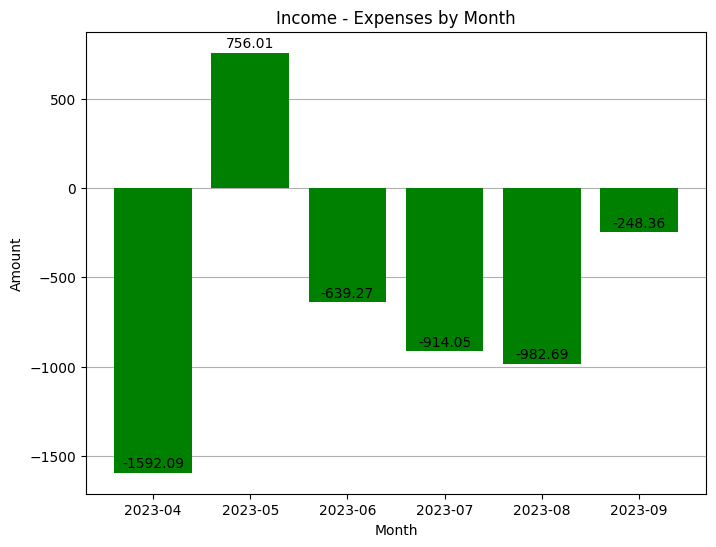


        1 - Expenses/Income over time per category
        2 - Expenses/Income over time for single category
        3 - Expenses/Income per day for a single month
        4 - Expenses/Income per category for a single month
        5 - Total Expense/Income per month
        6 - Income - Expenses per month
        0 - Exit
        
Choose type: 5
Expense/income: expense
Input start date (yyyy-mm): 


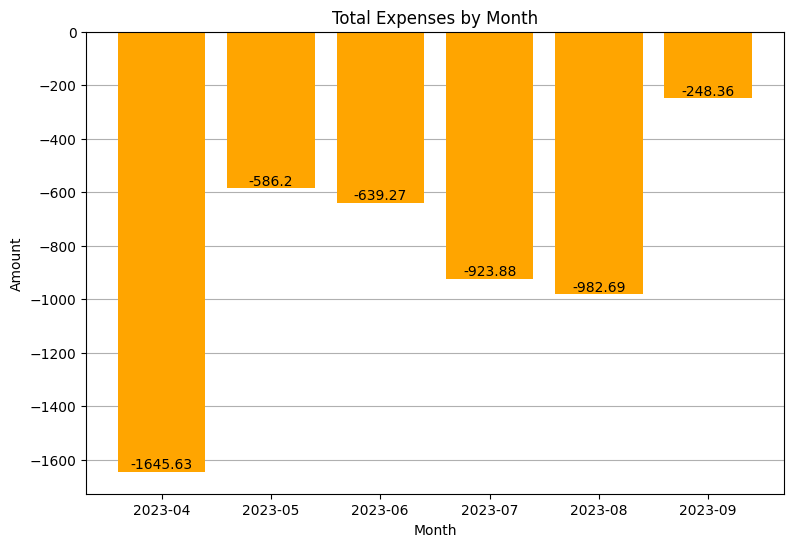


        1 - Expenses/Income over time per category
        2 - Expenses/Income over time for single category
        3 - Expenses/Income per day for a single month
        4 - Expenses/Income per category for a single month
        5 - Total Expense/Income per month
        6 - Income - Expenses per month
        0 - Exit
        
Choose type: 0

1 - start all
2 - see categorized data
3 - admin
4 - download file
5 - sync with admin
6 - analytics
0 - end

Input number: 1


Saving account-statement_2023-10-01_2023-12-31_en_c08123.csv to account-statement_2023-10-01_2023-12-31_en_c08123.csv
Input bank: Revolut

1 - start all
2 - see categorized data
3 - admin
4 - download file
5 - sync with admin
6 - analytics
0 - end

Input number: 6

        1 - Expenses/Income over time per category
        2 - Expenses/Income over time for single category
        3 - Expenses/Income per day for a single month
        4 - Expenses/Income per category for a single month
        5 - Total Expense/Income per month
        6 - Income - Expenses per month
        0 - Exit
        
Choose type: 6
Input start date (yyyy-mm): 


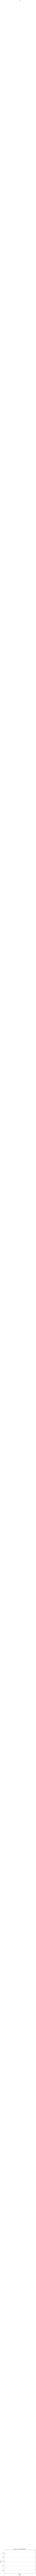


        1 - Expenses/Income over time per category
        2 - Expenses/Income over time for single category
        3 - Expenses/Income per day for a single month
        4 - Expenses/Income per category for a single month
        5 - Total Expense/Income per month
        6 - Income - Expenses per month
        0 - Exit
        
Choose type: 0

1 - start all
2 - see categorized data
3 - admin
4 - download file
5 - sync with admin
6 - analytics
0 - end

Input number: 1


Saving statement (1).csv to statement (1).csv
Input bank: Swedbank

1 - start all
2 - see categorized data
3 - admin
4 - download file
5 - sync with admin
6 - analytics
0 - end

Input number: 6

        1 - Expenses/Income over time per category
        2 - Expenses/Income over time for single category
        3 - Expenses/Income per day for a single month
        4 - Expenses/Income per category for a single month
        5 - Total Expense/Income per month
        6 - Income - Expenses per month
        0 - Exit
        
Choose type: 6
Input start date (yyyy-mm): 


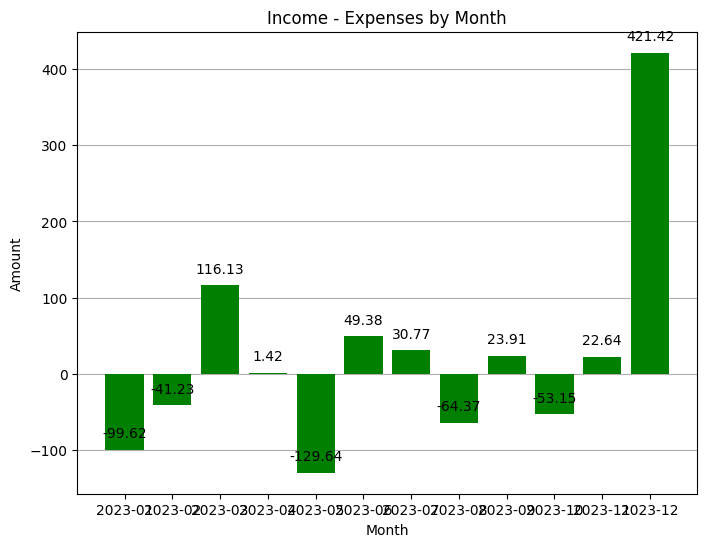


        1 - Expenses/Income over time per category
        2 - Expenses/Income over time for single category
        3 - Expenses/Income per day for a single month
        4 - Expenses/Income per category for a single month
        5 - Total Expense/Income per month
        6 - Income - Expenses per month
        0 - Exit
        
Choose type: 0

1 - start all
2 - see categorized data
3 - admin
4 - download file
5 - sync with admin
6 - analytics
0 - end

Input number: 0


In [ ]:
ievade = 1
check = 0
gc = authorize()
while ievade:
  print("""
1 - start all
2 - see categorized data
3 - admin
4 - download file
5 - sync with admin
6 - analytics
0 - end
""")
  ievade = int(input("Input number: "))
  while check == 0 and ievade != 1:
    print("You have to run 1 to access other options!")
    ievade = int(input("Input number: "))
  match ievade:
    case 1:
      if os.path.exists('/content/my_database.db'):
        os.remove('/content/my_database.db')
      conn, cursor = create_database(gc)
      df = upload_file()
      df = rearrange_data(df)
      df = clean_data(df)
      df = categorize_data(df, cursor)
    case 2:
      see_data_as_table(df)
    case 3:
      choice = 1
      while choice != 0:
        print("""
        1 - Query
        2 - Add new keyword
        3 - Add new country
        4 - Delete keyword
        5 - Delete country
        6 - Edit keyword
        7 - Edit country
        0 - Exit
        """)
        choice = int(input("Choose type: "))
        match choice:
          case 1:
            query_keywords(cursor)
            os.remove('/content/my_database.db')
            conn, cursor = create_database(gc)
          case 2:
            add_new_keyword()
            os.remove('/content/my_database.db')
            conn, cursor = create_database(gc)
          case 3:
            add_new_country()
            os.remove('/content/my_database.db')
            conn, cursor = create_database(gc)
          case 4:
            delete_keyword()
            os.remove('/content/my_database.db')
            conn, cursor = create_database(gc)
          case 5:
            delete_country()
            os.remove('/content/my_database.db')
            conn, cursor = create_database(gc)
          case 6:
            edit_keyword()
            os.remove('/content/my_database.db')
            conn, cursor = create_database(gc)
          case 7:
            edit_country()
            os.remove('/content/my_database.db')
            conn, cursor = create_database(gc)
          case 0:
            break
    case 4:
      download_csv(df)
    case 5:
      replace_data_with_admin()
    case 6:
      create_analytical_data(df, cursor, conn)
      choice = 1
      while choice != 0:
        print("""
        1 - Expenses/Income over time per category
        2 - Expenses/Income over time for single category
        3 - Expenses/Income per day for a single month
        4 - Expenses/Income per category for a single month
        5 - Total Expense/Income per month
        6 - Income - Expenses per month
        0 - Exit
        """)
        choice = int(input("Choose type: "))
        match choice:
          case 1:
            spent_per_cate()
          case 2:
            expense_over_time_for_cat()
          case 3:
            spent_each_day()
          case 4:
            category_month()
          case 5:
            total_expenses_month()
          case 6:
            total_income_expense()
          case 0:
            break
    case 0:
      close_db(conn)
      if os.path.exists('/content/my_database.db'):
        os.remove('/content/my_database.db')
      break
  check += 1


In [ ]:
"""
cursor.execute("SELECT * FROM Category")
columns = [desc[0] for desc in cursor.description]
adf = pd.DataFrame(cursor.fetchall(), columns=columns)
print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))

cursor.execute("SELECT * FROM Country")
columns = [desc[0] for desc in cursor.description]
adf = pd.DataFrame(cursor.fetchall(), columns=columns)
print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))


cursor.execute("SELECT * FROM Keyword")
columns = [desc[0] for desc in cursor.description]
adf = pd.DataFrame(cursor.fetchall(), columns=columns)
print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))

cursor.execute("SELECT criteria, category_name FROM Keyword join Category on Keyword.category = Category.category_id")
columns = [desc[0] for desc in cursor.description]
adf = pd.DataFrame(cursor.fetchall(), columns=columns)
print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))
"""

'\ncursor.execute("SELECT * FROM Category")\ncolumns = [desc[0] for desc in cursor.description]\nadf = pd.DataFrame(cursor.fetchall(), columns=columns)\nprint(tabulate(adf, headers=\'keys\', tablefmt=\'simple_grid\', showindex="never"))\n\ncursor.execute("SELECT * FROM Country")\ncolumns = [desc[0] for desc in cursor.description]\nadf = pd.DataFrame(cursor.fetchall(), columns=columns)\nprint(tabulate(adf, headers=\'keys\', tablefmt=\'simple_grid\', showindex="never"))\n\n\ncursor.execute("SELECT * FROM Keyword")\ncolumns = [desc[0] for desc in cursor.description]\nadf = pd.DataFrame(cursor.fetchall(), columns=columns)\nprint(tabulate(adf, headers=\'keys\', tablefmt=\'simple_grid\', showindex="never"))\n\ncursor.execute("SELECT criteria, category_name FROM Keyword join Category on Keyword.category = Category.category_id")\ncolumns = [desc[0] for desc in cursor.description]\nadf = pd.DataFrame(cursor.fetchall(), columns=columns)\nprint(tabulate(adf, headers=\'keys\', tablefmt=\'simple_gr

In [ ]:
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams

# Make sure to install nltk and pandas if not already installed
# pip install nltk pandas
a = 50

# Download NLTK resources (stopwords and punkt tokenizer)
import nltk
nltk.download('stopwords')
nltk.download('punkt')

def get_most_common_words(dataframe, column, n=50):
    """
    Get the most common words from a DataFrame column.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column (str): The name of the column to analyze.
        n (int): The number of most common words to retrieve. Default is 10.

    Returns:
        list: A list of tuples containing the most common words and their frequencies.
    """
    # Combine all text in the specified column
    all_text = ' '.join(dataframe[column].astype(str).values)

    # Tokenize the text
    words = word_tokenize(all_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    # Count word frequencies
    word_counts = Counter(words)

    # Get the most common words
    most_common_words = word_counts.most_common(n)

    return most_common_words

# Example usage:
# Assuming you have a DataFrame named 'df' with a column named 'text_column'
# Replace 'df' and 'text_column' with your actual DataFrame and column names

# most_common_words_result = get_most_common_words(df, 'text_column', n=10)
# print(most_common_words_result)
data = {'text_column': ["Iemaksa Krājrīkā pēc pirkuma 20.5 EUR /MCDONALDS/04.11.2023     ",
                        "PIRKUMS 557368******6167 02.11.2023 1.50 EUR (275726) dbs.rigassatiksme.lv LV-1067 Riga  ",
                        "Iemaksa Krājrīkā pēc pirkuma 8.99 EUR /Superalko/04.11.2023  "]}

df = pd.DataFrame(data)

# Example usage of the function
most_common_words_result = get_most_common_words(df, 'text_column', a)

# Display the result
print("Most Common Words:")
for word, count in most_common_words_result:
    print(f"{word}: {count}")

def get_most_common_ngrams(dataframe, column, n=2, top_n=50):
    """
    Get the most common n-grams from a DataFrame column.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column (str): The name of the column to analyze.
        n (int): The size of n-grams. Default is 2 for bigrams.
        top_n (int): The number of most common n-grams to retrieve. Default is 10.

    Returns:
        list: A list of tuples containing the most common n-grams and their frequencies.
    """
    # Combine all text in the specified column
    all_text = ' '.join(dataframe[column].astype(str).values)

    # Tokenize the text
    words = word_tokenize(all_text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    # Generate n-grams
    ngrams_list = list(ngrams(words, n))

    # Adjust n-grams to consider adjacent words
    ngrams_list = [(words[i], words[i + 1]) for i in range(len(words) - 1)]

    # Count n-gram frequencies
    ngram_counts = Counter(ngrams_list)

    # Get the most common n-grams
    most_common_ngrams = ngram_counts.most_common(top_n)

    return most_common_ngrams


# Example usage for bigrams
most_common_ngrams_result = get_most_common_ngrams(df, 'text_column', n=2, top_n=50)

# Display the result
print(f"Most Common 2-grams (Bigrams):")
for ngram, count in most_common_ngrams_result:
    print(f"{ngram}: {count}")


Most Common Words:
eur: 3
iemaksa: 2
krājrīkā: 2
pēc: 2
pirkuma: 2
pirkums: 1
riga: 1
Most Common 2-grams (Bigrams):
('iemaksa', 'krājrīkā'): 2
('krājrīkā', 'pēc'): 2
('pēc', 'pirkuma'): 2
('pirkuma', 'eur'): 2
('eur', 'pirkums'): 1
('pirkums', 'eur'): 1
('eur', 'riga'): 1
('riga', 'iemaksa'): 1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


┌──────────┬────────────┐
│ amount   │ category   │
├──────────┼────────────┤
└──────────┴────────────┘


Expense/income: income
Input start date (yyyy-mm): 


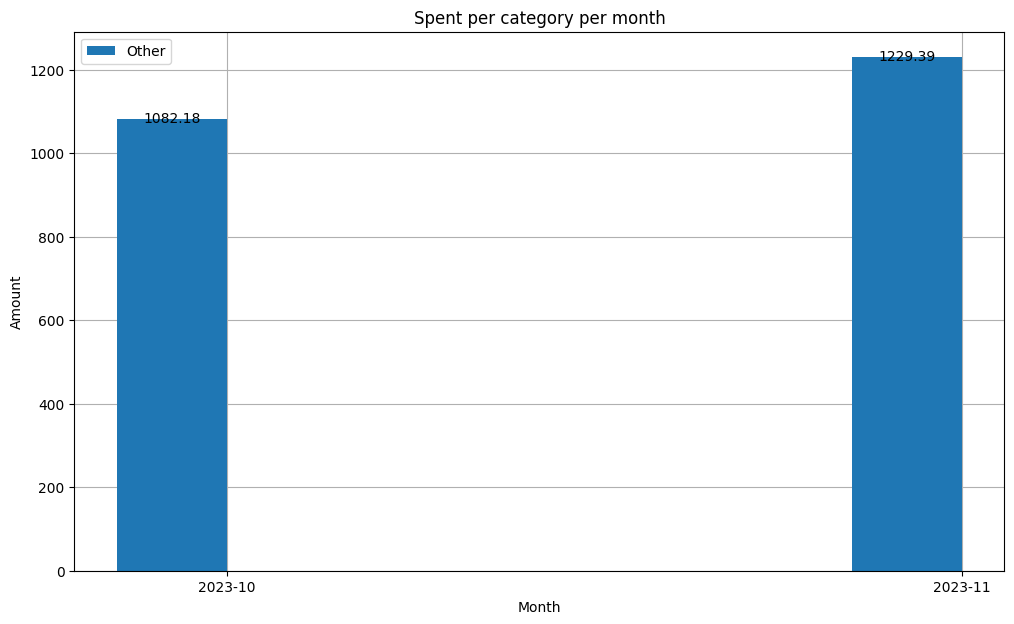

In [ ]:

spent_per_cate()

Expense/income: expense
Category: Food
Input start date (yyyy-mm): 
┌──────────────┬──────────┬────────────┐
│ short_date   │   amount │ category   │
├──────────────┼──────────┼────────────┤
│ 2023-10      │  -255.69 │ Food       │
├──────────────┼──────────┼────────────┤
│ 2023-11      │   -16.94 │ Food       │
└──────────────┴──────────┴────────────┘


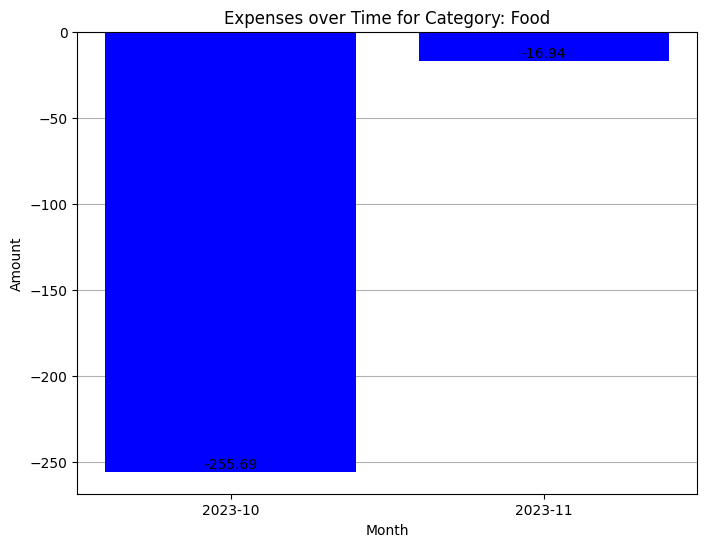

In [ ]:

expense_over_time_for_cat()

Input month: 2023-10


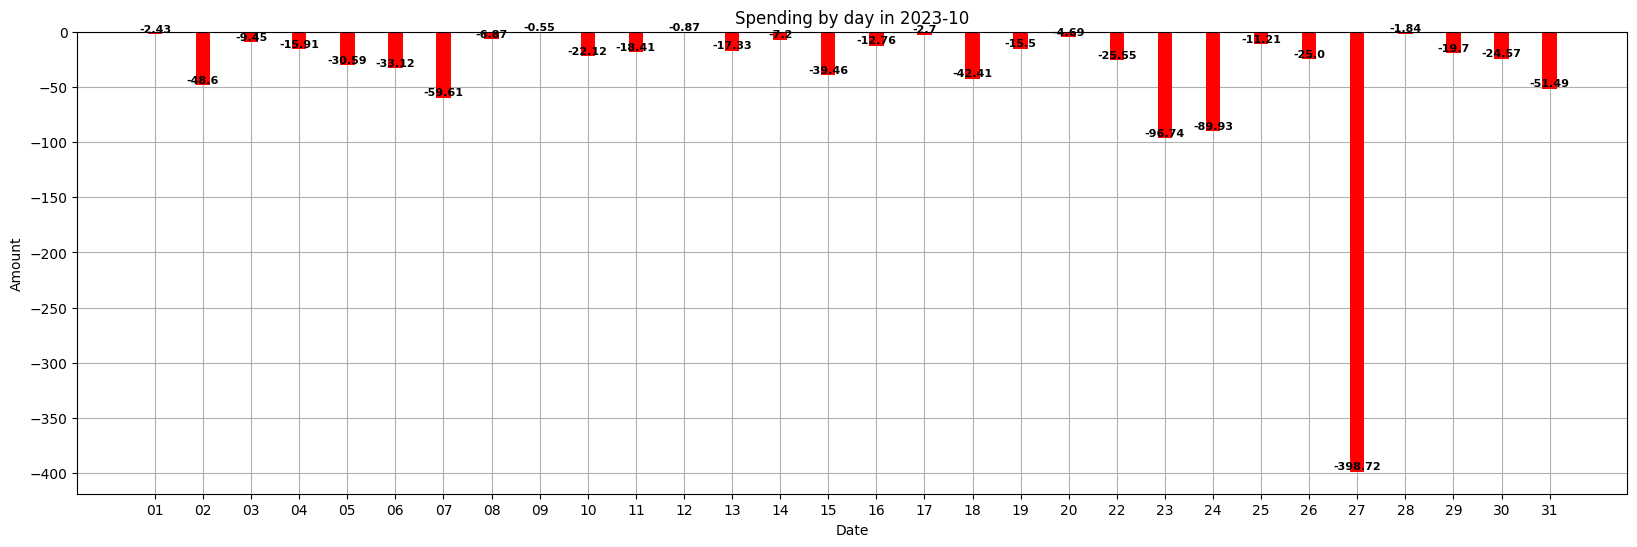

In [ ]:

spent_each_day()

Input month: 2023-10


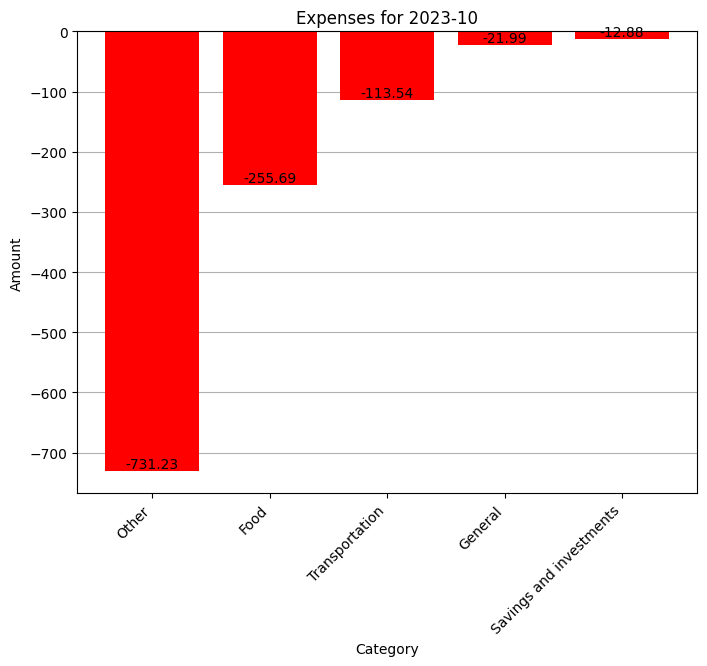

In [ ]:

category_month()

Expense/income: expense
Input start date (yyyy-mm): 


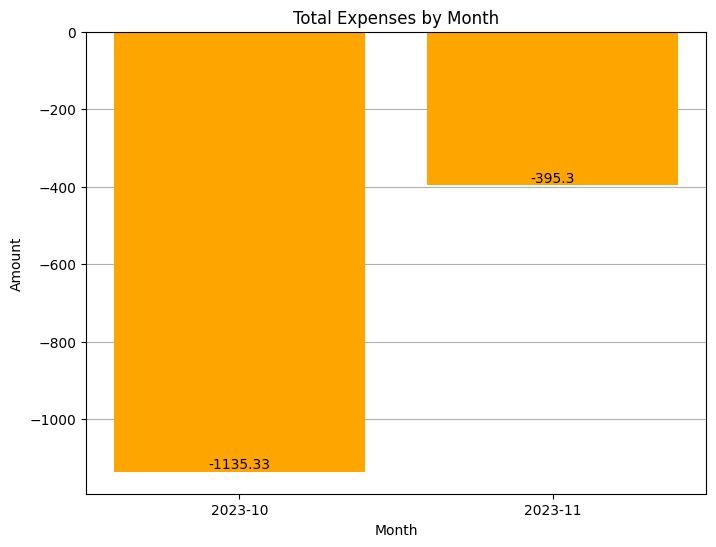

In [ ]:


total_expenses_month()

Input start date (yyyy-mm): 


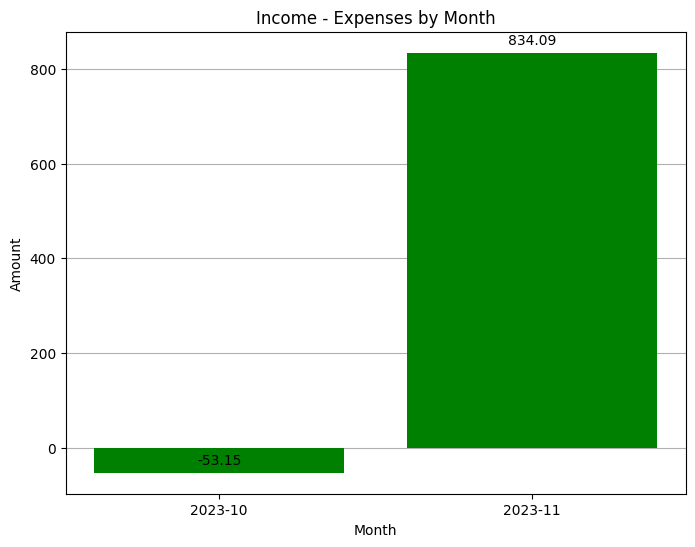

In [ ]:
def total_income_expense():
  start_date = input("Input start date (yyyy-mm): ")
  if start_date:
    end_date = input("Input end date (yyyy-mm): ")

  if start_date:
    cursor.execute(f"SELECT substr(t1.date, 1, 7) as short_date, (SUM(CASE WHEN t1.amount > 0 THEN t1.amount ELSE 0 END) + SUM(CASE WHEN t2.amount < 0 THEN t2.amount ELSE 0 END)) as amount2 FROM Categorized_data t1 JOIN Categorized_data t2 ON t1.id = t2.id WHERE substr(t1.date, 1, 7) >= '{start_date}' AND substr(t1.date, 1, 7) <= '{end_date}' GROUP BY short_date;")
  else:
    cursor.execute("SELECT substr(t1.date, 1, 7) as short_date, (SUM(CASE WHEN t1.amount > 0 THEN t1.amount ELSE 0 END) + SUM(CASE WHEN t2.amount < 0 THEN t2.amount ELSE 0 END)) as amount2 FROM Categorized_data t1 JOIN Categorized_data t2 ON t1.id = t2.id GROUP BY short_date;")
  columns = [desc[0] for desc in cursor.description]
  adf = pd.DataFrame(cursor.fetchall(), columns=columns)
  if adf.empty or (adf.shape[0] == 0 and adf.shape[1] > 0):
    print("There is no data to display or date input was incorrect")
  else:
    #print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))

    # Plotting the dynamic bar chart with values at the top
    num_data_points = len(adf)
    figure_size = (min(15, max(num_data_points / 5, 8)), 6)

    plt.figure(figsize=figure_size)
    bars = plt.bar(adf['short_date'], adf['amount2'], color='green', zorder=2)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 12, round(yval, 2), ha='center', va='bottom')

    plt.title("Income - Expenses by Month")
    plt.xlabel("Month")
    plt.ylabel("Amount")
    plt.grid(axis='y')


    plt.show()
total_income_expense()

┌──────────┬─────────────────────────┐
│   amount │ category                │
├──────────┼─────────────────────────┤
│  -731.23 │ Other                   │
├──────────┼─────────────────────────┤
│  -255.69 │ Food                    │
├──────────┼─────────────────────────┤
│  -113.54 │ Transportation          │
├──────────┼─────────────────────────┤
│   -21.99 │ General                 │
├──────────┼─────────────────────────┤
│   -12.88 │ Savings and investments │
└──────────┴─────────────────────────┘
┌──────────┬─────────────────────────┐
│   Amount │ Category                │
├──────────┼─────────────────────────┤
│  -731.23 │ Other                   │
├──────────┼─────────────────────────┤
│  -255.69 │ Food                    │
├──────────┼─────────────────────────┤
│  -113.54 │ Transportation          │
├──────────┼─────────────────────────┤
│   -21.99 │ General                 │
├──────────┼─────────────────────────┤
│   -12.88 │ Savings and investments │
└──────────┴─────────────

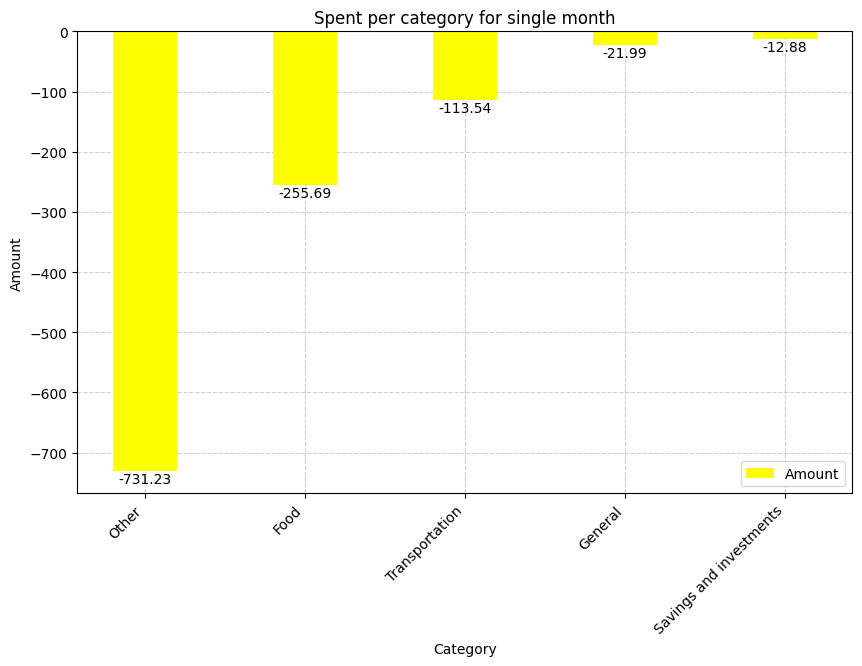

┌──────────┐
│   amount │
├──────────┤
│ -1135.33 │
└──────────┘
┌──────────────┬──────────┐
│   short_date │   amount │
├──────────────┼──────────┤
│           10 │ -1135.33 │
├──────────────┼──────────┤
│           11 │  -395.3  │
└──────────────┴──────────┘


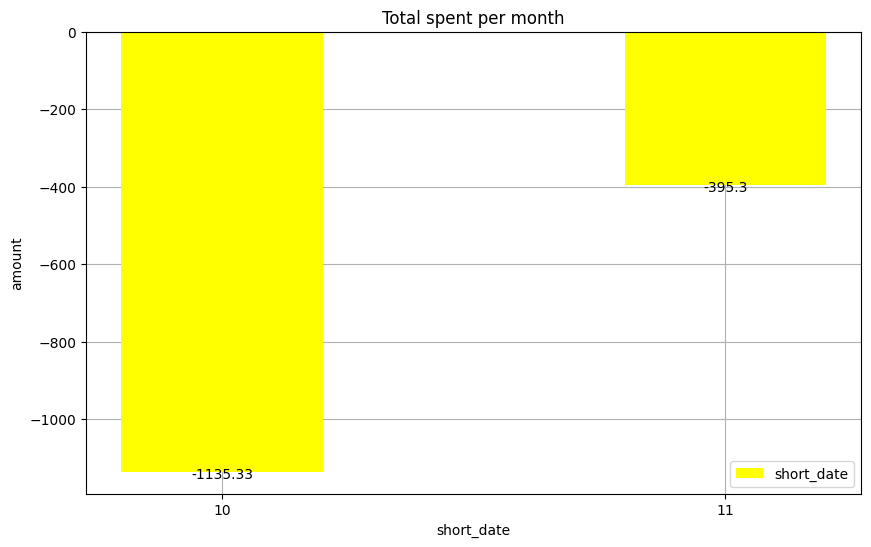

┌──────────────┬───────────┐
│   short_date │   amount2 │
├──────────────┼───────────┤
│           10 │    -53.15 │
├──────────────┼───────────┤
│           11 │    834.09 │
└──────────────┴───────────┘
┌──────┬────────────┬──────────┬─────────────────────────┐
│   id │ date       │   amount │ category                │
├──────┼────────────┼──────────┼─────────────────────────┤
│    1 │ 2023-10-01 │    -1.74 │ Food                    │
├──────┼────────────┼──────────┼─────────────────────────┤
│    2 │ 2023-10-01 │    15    │ Other                   │
├──────┼────────────┼──────────┼─────────────────────────┤
│    3 │ 2023-10-01 │    -0.69 │ Savings and investments │
├──────┼────────────┼──────────┼─────────────────────────┤
│    4 │ 2023-10-02 │   -48.6  │ Other                   │
├──────┼────────────┼──────────┼─────────────────────────┤
│    5 │ 2023-10-03 │    -9.31 │ Food                    │
└──────┴────────────┴──────────┴─────────────────────────┘


'\n\n'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



#test("SELECT sum(amount) as amount FROM Categorized_data WHERE amount < 0 and substr(date, 6, 2) = ? ORDER BY amount", (str(month),), 'Total spent in a month')




#all
cursor.execute("SELECT * FROM Categorized_data LIMIT 5")
columns = [desc[0] for desc in cursor.description]
adf = pd.DataFrame(cursor.fetchall(), columns=columns)
print(tabulate(adf, headers='keys', tablefmt='simple_grid', showindex="never"))

'''

'''

In [ ]:
data = {
    'Type': ['TOPUP', 'TRANSFER', 'TOPUP', 'EXCHANGE'],
    'Product': ['Current', 'Current', 'Current', 'Current'],
    'Started Date': ['21.11.2023 20:11', '21.11.2023 20:12', '21.11.2023 20:13', '21.11.2023 20:13'],
    'Completed Date': ['21.11.2023 20:11', '21.11.2023 20:12', '21.11.2023 20:13', '21.11.2023 20:13'],
    'Description': ['Top-Up by *6167', 'To investment account', 'From investment account', 'Exchanged to USD'],
    'Amount': [100.00, -100.00, 100.00, -100.00],
    'Fee': [0.00, 0.00, 0.00, 0.00],
    'Currency': ['EUR', 'EUR', 'EUR', 'EUR'],
    'State': ['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED'],
    'Balance': [100.57, 0.57, 100.57, 0.57]
}

#df = pd.DataFrame(data)

print(df)
print(pd.to_datetime(df['date']))
# Condition check
bank = 'Revolut'  # Replace with your actual bank variable
if bank.lower().strip() == 'revolut':
    # Operations on DataFrame
    cols = df.columns.to_list()
    cols = cols[3:8]
    df = df.reindex(columns=cols)

    if 'Fee' in df.columns:
        df.drop('Fee', axis=1, inplace=True)

    cols = df.columns.to_list()
    index_to_insert = cols.index('Completed Date') + 1
    cols.insert(index_to_insert, 'creditor/debtor')
    df = df.reindex(columns=cols)
    df['creditor/debtor'] = ' '
    df['Completed Date'] = df['Completed Date'].str[:10]
    cols = df.columns.to_list()
    column_rename_mapping = {
        'Completed Date': 'date',
        'Description': 'remittance_information',
        'Amount': 'amount',
        'Currency': 'currency',
    }


    df = df.rename(columns=column_rename_mapping)
    cols = df.columns.to_list()
    index_to_insert = cols.index('remittance_information') + 1
    cols.insert(index_to_insert, 'clean_text')
    df = df.reindex(columns=cols)

# Display the modified DataFrame
print(df)

                clean_text  amount currency category
0           top up by 6167   100.0      EUR    Other
1    to investment account  -100.0      EUR    Other
2  from investment account   100.0      EUR    Other
3         exchanged to usd  -100.0      EUR    Other


KeyError: ignored

In [ ]:
bank = 'revolu'
banks = ['swedbank', 'revolut']
while bank.lower().strip() not in banks:
    print("Bank not supported or invalid input!")
    bank = str(input('Input bank: '))

Bank not supported or invalid input!


KeyboardInterrupt: ignored

In [ ]:
while True:
    try:
        priority = int(input("Priority: "))
        if 0 <= priority <= 100:
            break  # If the input is a valid integer within the range, exit the loop
        else:
            print("Priority must be between 0 and 100. Please try again.")
    except ValueError:
        print("Invalid input. Please enter a valid integer.")

Priority: -1
Priority must be between 0 and 100. Please try again.
Priority: 3.4
Invalid input. Please enter a valid integer.
Priority: a
Invalid input. Please enter a valid integer.
Priority: 4


In [ ]:
uploaded = files.upload()
for file_name, file_content in uploaded.items():
        try:
            df = pd.read_csv(io.StringIO(file_content.decode('utf-8')), sep=",")
        except pd.errors.ParserError:
            df = pd.read_csv(io.StringIO(file_content.decode('utf-8')), sep=";")



df = df[['Completed Date', 'Description', 'Amount', 'Currency']]

cols = df.columns.to_list()
index_to_insert = cols.index('Completed Date') + 1
cols.insert(index_to_insert, 'creditor/debtor')
df = df.reindex(columns=cols)
df['creditor/debtor'] = ' '
df['Completed Date'] = df['Completed Date'].str[:10]
cols = df.columns.to_list()
column_rename_mapping = {
          'Completed Date': 'date',
          'Description': 'remittance_information',
          'Amount': 'amount',
          'Currency': 'currency',
}

df = df.rename(columns=column_rename_mapping)

df.head()

Saving account-statement_2023-10-01_2023-12-31_en_c08123.csv to account-statement_2023-10-01_2023-12-31_en_c08123 (3).csv


,date,creditor/debtor,remittance_information,amount,currency
0,2023-11-21,,Top-Up by *6167,100.0,EUR
1,2023-11-21,,To investment account,-100.0,EUR
2,2023-11-21,,From investment account,100.0,EUR
3,2023-11-21,,Exchanged to USD,-100.0,EUR
